In [3]:
import monte_carlo.montecarlo as mt
import matplotlib.pyplot as plt

In [4]:
inf = mt.simulate_inflacao(12,2026)

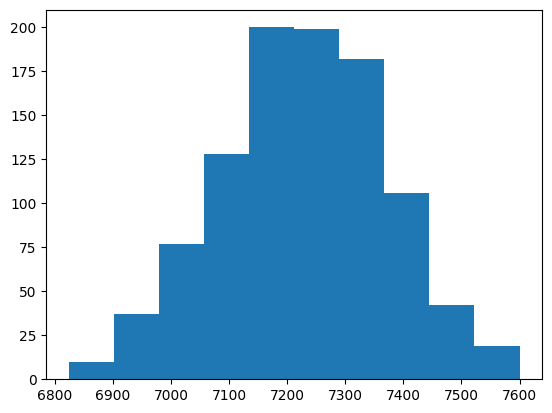

In [7]:
_ = plt.hist(inf)